In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [2]:
ts_fb= pd.read_csv('https://www.dropbox.com/s/j04e6thkqmk02z1/LPL.csv?dl=1',
                   header=0,
                   index_col=0,
                   parse_dates=True)

ts_fb.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,8.78,8.80,8.60,8.66,8.66,256300
2021-01-05,8.59,8.65,8.56,8.64,8.64,168200
2021-01-06,8.86,9.03,8.84,8.96,8.96,522200
2021-01-07,9.08,9.17,9.05,9.16,9.16,305200
2021-01-08,9.15,9.27,9.14,9.21,9.21,530800


In [3]:
ts_fb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2021-01-04 to 2021-03-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       48 non-null     float64
 1   High       48 non-null     float64
 2   Low        48 non-null     float64
 3   Close      48 non-null     float64
 4   Adj Close  48 non-null     float64
 5   Volume     48 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 2.6 KB


In [4]:
ts_fb['Open']['2021-01']

Date
2021-01-04     8.78
2021-01-05     8.59
2021-01-06     8.86
2021-01-07     9.08
2021-01-08     9.15
2021-01-11     8.93
2021-01-12     9.10
2021-01-13     9.27
2021-01-14     9.75
2021-01-15     9.55
2021-01-19     9.57
2021-01-20     9.72
2021-01-21    10.50
2021-01-22    10.57
2021-01-25    10.65
2021-01-26    10.86
2021-01-27    10.23
2021-01-28    10.12
2021-01-29     9.76
Name: Open, dtype: float64

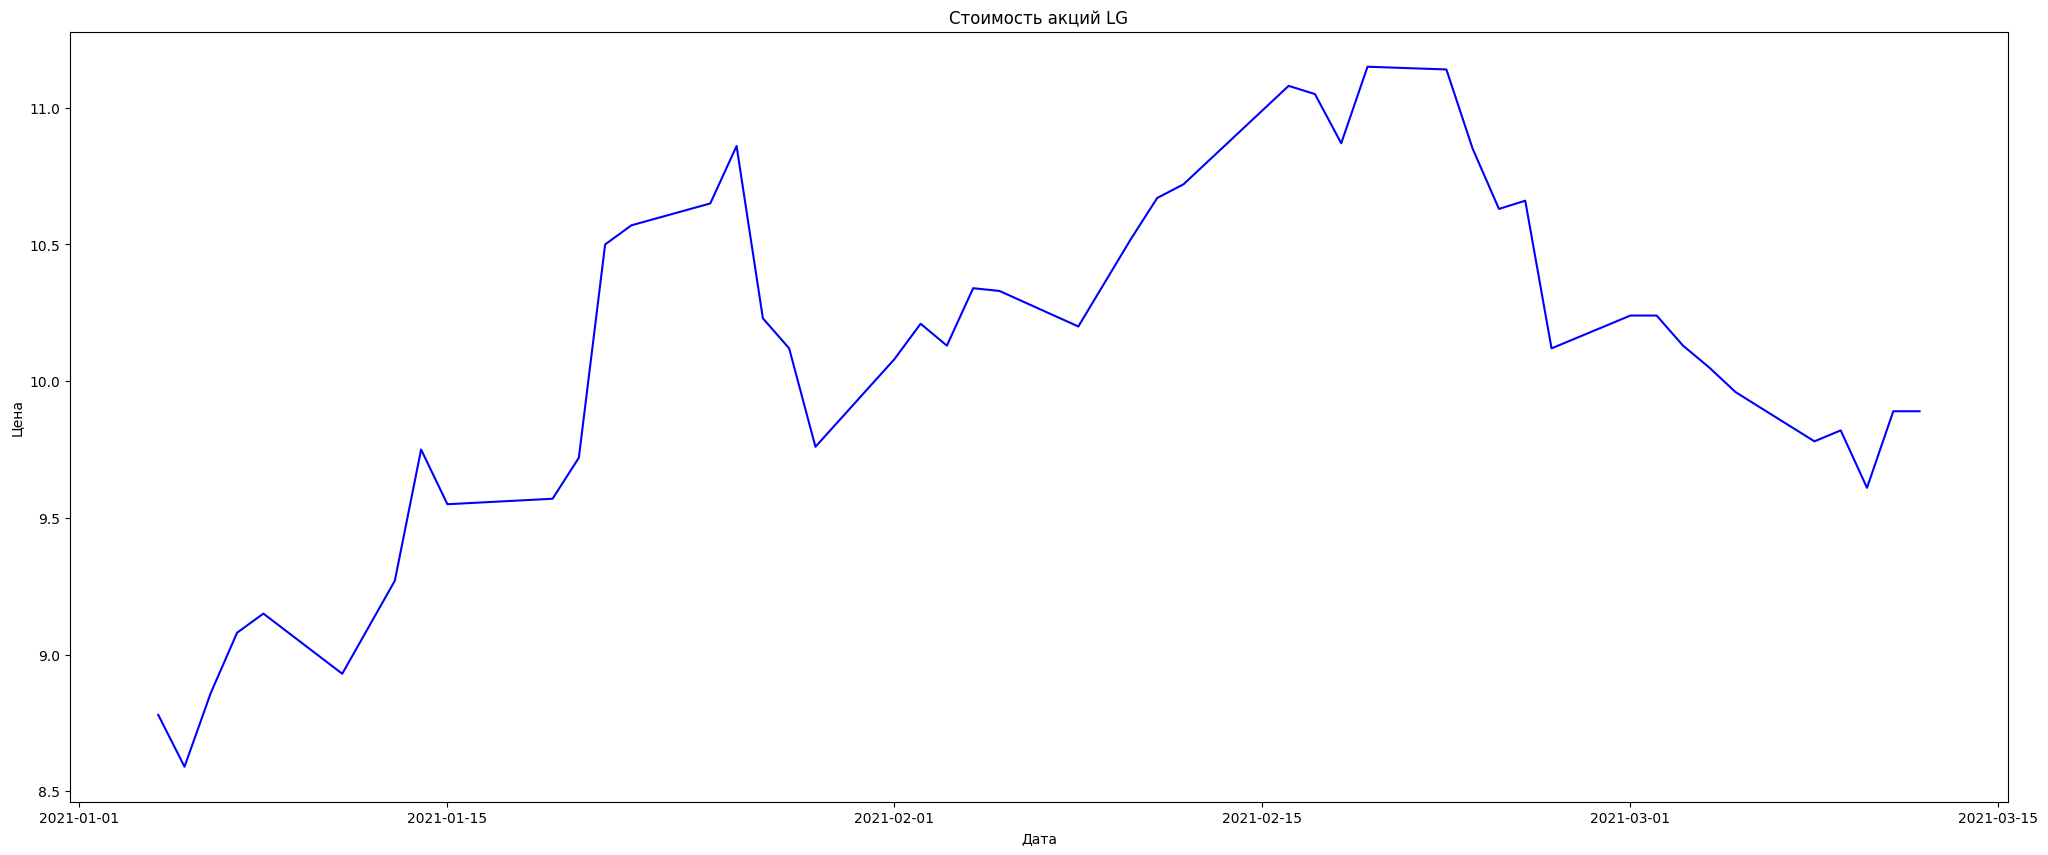

In [5]:
plt.figure(figsize = (25, 10))
plt.title('Стоимость акций LG') 
plt.xlabel('Дата') 
plt.ylabel('Цена') 
plt.plot(ts_fb['Open'], 'blue', label = 'Тренировочные данные')

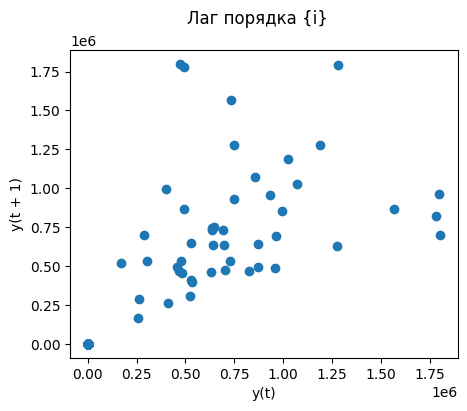

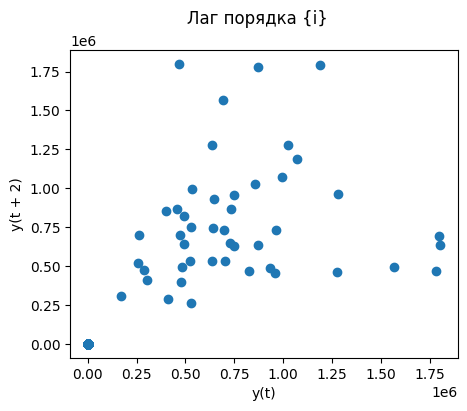

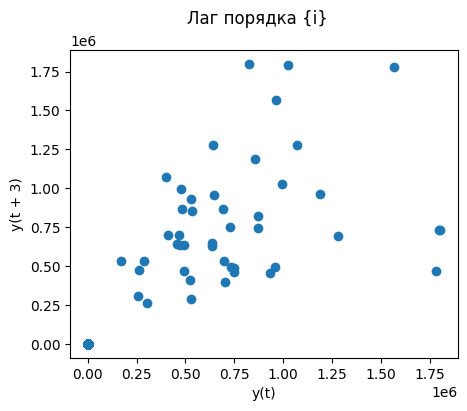

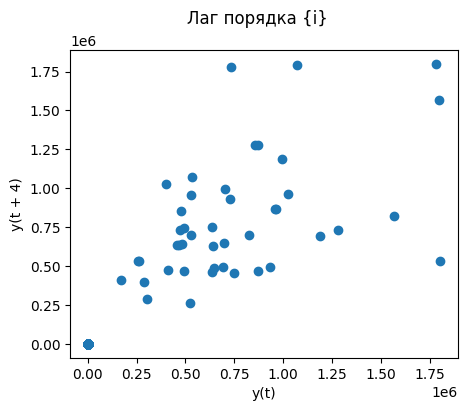

In [6]:
#Создание графиков лаговой автокорреляции:
for i in range(1, 5):
    fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle('Лаг порядка {i}')
    pd.plotting.lag_plot(ts_fb, lag=i, ax=ax)
    pyplot.show()

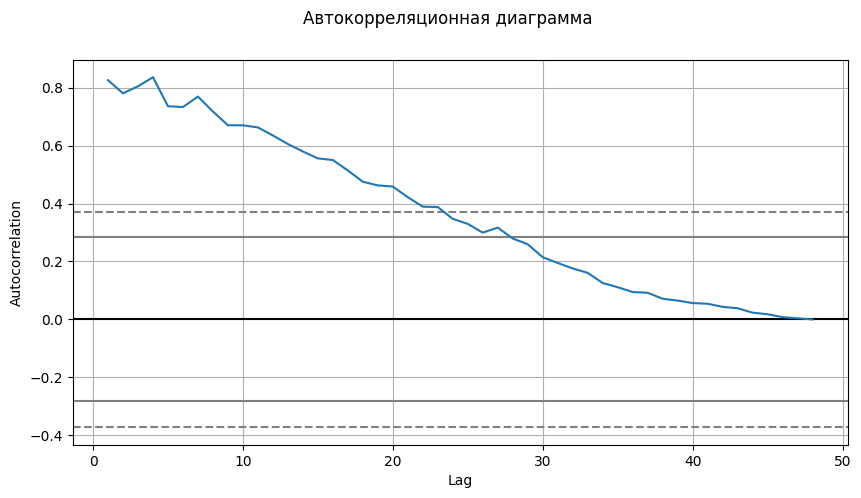

In [7]:
#Создание графика автокорреляционной функции:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Автокорреляционная диаграмма')
pd.plotting.autocorrelation_plot(ts_fb, ax=ax)
pyplot.show()

## Прогнозирование временного ряда авторегрессионными методами

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [9]:
#Подготовка данных для модели ARIMA:
X = list(range(ts_fb.shape[0]))
y = ts_fb['Open'].values

In [10]:
#Прогнозирование цен с помощью модели ARIMA и сохранение прогнозов:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.8)

In [11]:
history = [y for y in y_train]
predictions = list()
for t in range(len(y_test)):
    model = ARIMA(history, order = (5, 1, 0)) 
    model_fit = model.fit() 
    yhat = model_fit.forecast()[0]
    predictions.append(yhat) 
    history.append(y_test[t])

In [12]:
#Добавление прогнозов и исходных данных в исходный DataFrame:
ts_fb['ARIMA'] = (len(X_train) * [np.NAN]) + list(predictions)
ts_fb['test'] = (len(X_train) * [np.NAN]) + list(y_test)
ts_fb['train'] = list(y_train) + (len(X_test) * [np.NAN])

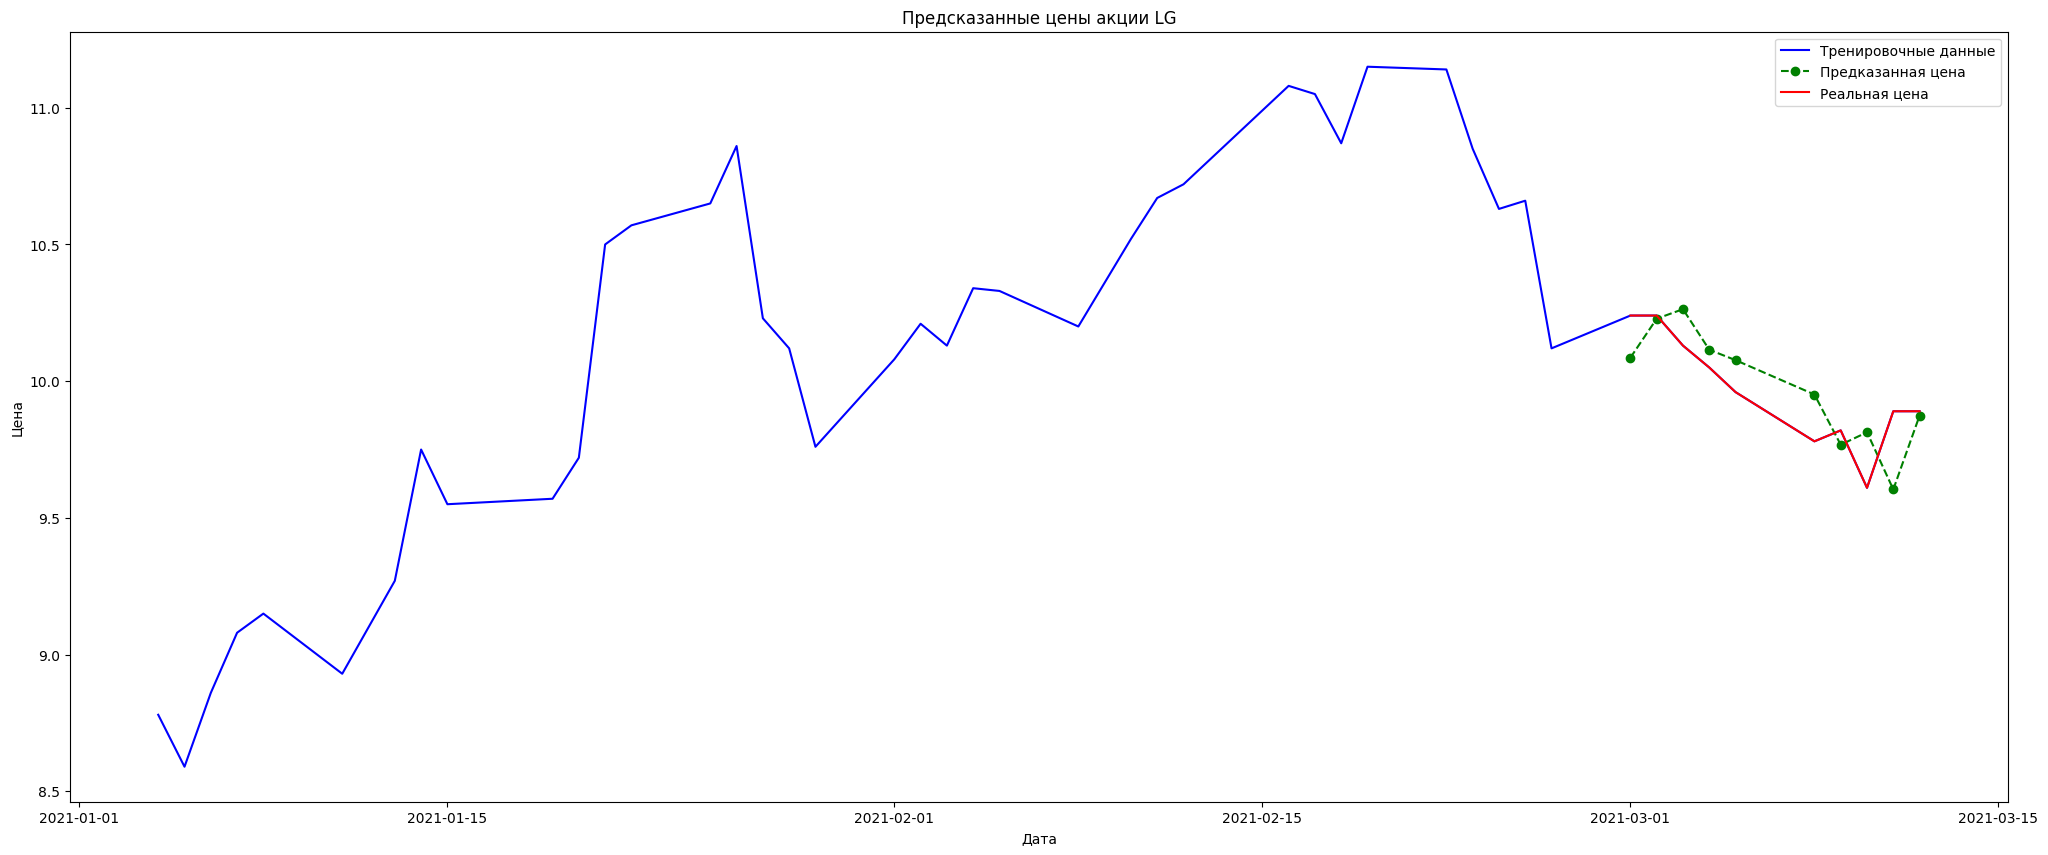

In [13]:
#Визуализация прогнозируемых и реальных цен с использованием модели ARIMA:
plt.figure(figsize = (25, 10))
plt.plot(ts_fb['Open'], color = 'blue', label = 'Тренировочные данные') 
plt.plot(ts_fb.index, ts_fb['ARIMA'], color = 'green', marker = 'o', linestyle = 'dashed', label = 'Предказанная цена')
plt.plot(ts_fb.index, ts_fb['test'], color = 'red', label = 'Реальная цена')
plt.title('Предсказанные цены акции LG') 
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()

## Прогнозирование временного ряда методом символьной регресии

import sys
!{sys.executable} -m pip install gplearn

In [14]:
from gplearn.genetic import SymbolicRegressor

In [17]:
#использование SymbolicRegressor для прогнозирования цен с использованием генетического программирования:function_set = ['add', 'sub', 'mul', 'div', 'sin', 'sqrt']
function_set = ['add', 'sub', 'mul', 'div', 'sin', 'sqrt']
est_gp = SymbolicRegressor(population_size=100, metric='mse',
                               generations=60, stopping_criteria=0.01,
                               init_depth=(4, 10), verbose=1, function_set=function_set,
                               const_range=(-100, 100), random_state=0)

In [18]:
est_gp.fit(np.array(X_train).reshape(-1, 1), y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   139.53      1.81723e+34       27          12.2766              N/A     15.32s
   1    68.47          4638.27       36         0.502071              N/A      7.85s
   2    32.11          9207.89       41         0.152806              N/A      7.33s
   3    34.51          270.283       41         0.152806              N/A     10.81s
   4    38.49          41.8878       41         0.141622              N/A      5.38s
   5    38.54          233.437       44         0.138505              N/A      7.51s
   6    39.90          282.588       41         0.138393              N/A      6.27s
   7    42.32          39.5408       44         0.138367              N/A      8.66s
   8    37.67          112.575       41         0.138393              N/A  

SymbolicRegressor(const_range=(-100, 100),
                  function_set=['add', 'sub', 'mul', 'div', 'sin', 'sqrt'],
                  generations=60, init_depth=(4, 10), metric='mse',
                  population_size=100, random_state=0, stopping_criteria=0.01,
                  verbose=1)

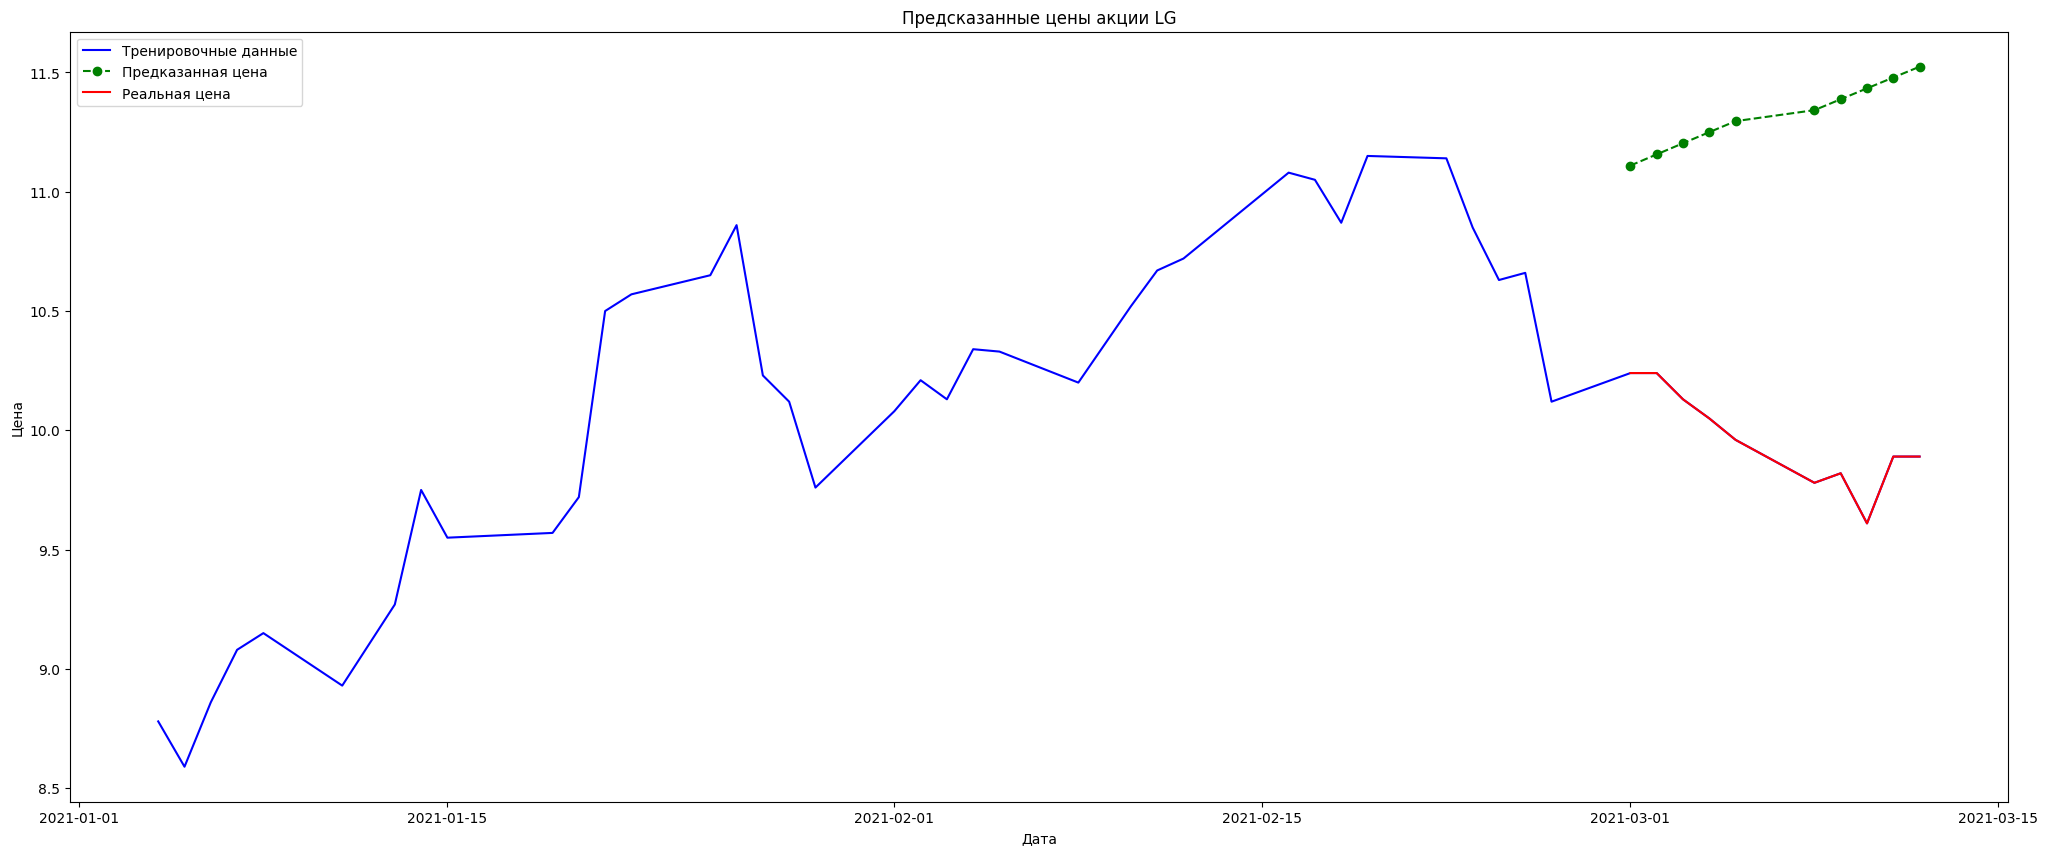

In [19]:
y_gp = est_gp.predict(np.array(X_test).reshape(-1, 1))
ts_fb['GPLEARN'] = (len(X_train) * [np.NAN]) + list(y_gp)

plt.figure(figsize = (25, 10))
plt.plot(ts_fb['Open'], color = 'blue', label = 'Тренировочные данные')
plt.plot(ts_fb.index, ts_fb['GPLEARN'], color = 'green', marker = 'o', linestyle = 'dashed', label = 'Предказанная цена')
plt.plot(ts_fb.index, ts_fb['test'], color = 'red', label = 'Реальная цена')
plt.title('Предсказанные цены акции LG') 
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()

## Сравнение 2 методов

In [20]:
#Вычисление среднеквадратичной ошибки (Mean Squared Error) для моделей ARIMA и SymbolicRegressor:
mean_squared_error(y_test, predictions), mean_squared_error(y_test, y_gp)

(0.021489400305944338, 1.9387660240167992)